[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/corazzon/seoul-bike-analysis/blob/master/ml-regression.ipynb)

# 여의나루역(대여소 번호 207)에서 대여하고 반납한 자전거의 이력을 분석
* 여의나루역은 같은 대여소에서 대여반납이 가장 많은 지역
* 대여와 반납이 여의나루역인 데이터
* 2017년 1월부터 2019년 5월까지의 데이터를 사용

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Window 의 한글 폰트 설정
# plt.rc('font',family='Malgun Gothic')
# Mac 의 한글 폰트 설정
plt.rc('font', family='AppleGothic') 
plt.rc('axes', unicode_minus=False)

%matplotlib inline

## Colab 에서 실행을 위한 코드
* colab : https://colab.research.google.com/github/corazzon/seoul-bike-analysis/blob/master/ml-regression.ipynb
* 아래의 코드는 google colaboratory 에서 실행을 위한 코드로 로컬 아나콘다에서는 주석처리한다.
* google colaboratory 에서는 주석을 풀고 폰트 설정과 csv 파일을 불러온다.

In [2]:
# 나눔고딕 설치
!apt -qq -y install fonts-nanum > /dev/null

import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
fm._rebuild()

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

In [3]:
# 구글 드라이브에서 csv 파일을 읽어오기 위해 gauth 인증을 한다.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# PyDrive client 인증
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 2.9MB/s 


In [5]:
# 공유 가능한 링크로 파일 가져오기
url ='https://drive.google.com/open?id=1ngU6y2Fl0cz6ckCuWvXSHKs5aLsh48TH'
id = url.split('=')[1]
print(id)
downloaded = drive.CreateFile({'id':id}) 
# data 폴더에 파일을 관리하며, 폴더가 없다면 만들어서 파일을 관리하도록 한다.
%mkdir data
downloaded.GetContentFile('data/bike-station-207.csv')  

1ngU6y2Fl0cz6ckCuWvXSHKs5aLsh48TH


In [6]:
df = pd.read_csv("data/bike-station-207.csv", low_memory=False)

df.shape

(259149, 7)

In [0]:
# 반납, 대여 모두 같은 207로 데이터 크기를 줄여서 예측한다.
df = df[(df["대여대여소번호"] == 207) & (df["반납대여소번호"] == 207)].copy()

In [8]:
df.shape

(48508, 7)

In [9]:
df.head(3)

,자전거번호SPB,대여일시,대여대여소번호,반납일시,반납대여소번호,이용시간(분),이용거리(M)
4,4563,2017-01-01 12:54,207,2017-01-01 13:42,207,47,2700.0
5,1886,2017-01-01 12:57,207,2017-01-01 13:42,207,44,3340.0
11,2166,2017-01-01 16:46,207,2017-01-01 17:37,207,50,6730.0


In [10]:
df.tail(3)

,자전거번호SPB,대여일시,대여대여소번호,반납일시,반납대여소번호,이용시간(분),이용거리(M)
259106,23431,2019-05-31 22:43:05,207,2019-05-31 23:39:24,207,54,7200.0
259144,18210,2019-05-31 23:34:38,207,2019-06-01 00:59:53,207,84,10080.0
259145,13394,2019-05-31 23:34:11,207,2019-06-01 01:00:16,207,85,10070.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48508 entries, 4 to 259145
Data columns (total 7 columns):
자전거번호SPB    48508 non-null int64
대여일시        48508 non-null object
대여대여소번호     48508 non-null int64
반납일시        48508 non-null object
반납대여소번호     48508 non-null int64
이용시간(분)     48508 non-null int64
이용거리(M)     48508 non-null float64
dtypes: float64(1), int64(4), object(2)
memory usage: 3.0+ MB


In [12]:
# object 타입에는 .dt accessor를 사용할 수 없기 때문에
# 대여일시와 반납일시를 datetime 형태로 변환해 줍니다.
df["대여일시"] = pd.to_datetime(df["대여일시"])
df["반납일시"] = pd.to_datetime(df["반납일시"])

df[["대여일시", "반납일시"]].dtypes

대여일시    datetime64[ns]
반납일시    datetime64[ns]
dtype: object

In [13]:
df["대여연도"] = df["대여일시"].dt.year
df["대여월"] = df["대여일시"].dt.month
df["대여일"] = df["대여일시"].dt.day
df["대여시간"] = df["대여일시"].dt.hour
df["대여요일"] = df["대여일시"].dt.dayofweek
df["대여일자"] = df["대여일시"].dt.date

df.sample()

,자전거번호SPB,대여일시,대여대여소번호,반납일시,반납대여소번호,이용시간(분),이용거리(M),대여연도,대여월,대여일,대여시간,대여요일,대여일자
125206,6325,2018-06-03 13:04:45,207,2018-06-03 14:18:08,207,72,11760.0,2018,6,3,13,6,2018-06-03


In [14]:
df["반납연도"] = df["반납일시"].dt.year
df["반납월"] = df["반납일시"].dt.month
df["반납일"] = df["반납일시"].dt.day
df["반납시간"] = df["반납일시"].dt.hour
df["반납요일"] = df["반납일시"].dt.dayofweek
df["반납일자"] = df["반납일시"].dt.date

df.sample()

,자전거번호SPB,대여일시,대여대여소번호,반납일시,반납대여소번호,이용시간(분),이용거리(M),대여연도,대여월,대여일,대여시간,대여요일,대여일자,반납연도,반납월,반납일,반납시간,반납요일,반납일자
220434,5096,2019-04-12 15:38:36,207,2019-04-12 16:37:27,207,57,6450.0,2019,4,12,15,4,2019-04-12,2019,4,12,16,4,2019-04-12


In [15]:
df.columns

Index(['자전거번호SPB', '대여일시', '대여대여소번호', '반납일시', '반납대여소번호', '이용시간(분)', '이용거리(M)',
       '대여연도', '대여월', '대여일', '대여시간', '대여요일', '대여일자', '반납연도', '반납월', '반납일',
       '반납시간', '반납요일', '반납일자'],
      dtype='object')

# 학습과 예측에 사용할 컬럼 만들기

In [16]:
# 학습과 예측에 사용할 컬럼
# 이용거리를 피처에 추가하고 제외해 본다.
feature_columns = ['자전거번호SPB', '대여대여소번호', '반납대여소번호','이용시간(분)',
       '대여연도', '대여월', '대여일', '대여시간', '대여요일', '반납연도', '반납월', '반납일',
       '반납시간', '반납요일']
feature_columns

['자전거번호SPB',
 '대여대여소번호',
 '반납대여소번호',
 '이용시간(분)',
 '대여연도',
 '대여월',
 '대여일',
 '대여시간',
 '대여요일',
 '반납연도',
 '반납월',
 '반납일',
 '반납시간',
 '반납요일']

In [17]:
label_column = "이용거리(M)"
label_column

'이용거리(M)'

# 학습과 예측에 사용할 데이터 세트 나누기

In [18]:
df[label_column].describe()

count     48508.000000
mean       7130.801847
std        8845.805091
min           0.000000
25%        3620.000000
50%        5850.000000
75%        8540.000000
max      253750.000000
Name: 이용거리(M), dtype: float64

In [19]:
df[df[label_column] == df[label_column].max()]

,자전거번호SPB,대여일시,대여대여소번호,반납일시,반납대여소번호,이용시간(분),이용거리(M),대여연도,대여월,대여일,대여시간,대여요일,대여일자,반납연도,반납월,반납일,반납시간,반납요일,반납일자
197881,13645,2018-11-13 12:31:27,207,2018-11-13 12:47:55,207,16,253750.0,2018,11,13,12,1,2018-11-13,2018,11,13,12,1,2018-11-13


In [20]:
# 90% 는 학습에 사용하고 10%는 예측에 사용합니다.
split_index = round(df.shape[0] * 0.9)
split_index

43657

In [21]:
# 데이터를 학습과 예측에 사용할 용도로 나눕니다.
# 파이썬의 슬라이싱 기능을 활용해서 나눕니다.
train = df[:split_index].copy()
test = df[split_index:].copy()

print("학습 데이터 크기", train.shape)
print("테스트 데이터 크기", test.shape)

학습 데이터 크기 (43657, 19)
테스트 데이터 크기 (4851, 19)


In [22]:
# 학습, 예측에 사용할 컬럼만 추출
X_train = train[feature_columns].copy()
X_test = test[feature_columns].copy()

print("학습에 사용할 피처 크기", X_train.shape)
print("예측에 사용할 피처 크기", X_test.shape)

학습에 사용할 피처 크기 (43657, 14)
예측에 사용할 피처 크기 (4851, 14)


In [23]:
y_train = train[label_column]
y_train.head()

4     2700.0
5     3340.0
11    6730.0
12    7120.0
13    9960.0
Name: 이용거리(M), dtype: float64

# 머신러닝 모델을 사용해서 학습과 예측하기

## 랜덤포레스트 사용하기

In [24]:
from sklearn.ensemble import RandomForestRegressor

# n_estimators 는 트리의 갯수를 의미하며
# random_state 는 옵션값을 고정해서 동일 조건에서 같은 값을 반환하도록 한다.
# n_jobs 는 사용할 CPU의 코어수를 지정하는데 -1로 지정하면 장비에 있는 CPU코어를 모두 사용하게 한다.

# 모델 선언
rfr = RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1)
# 학습
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [25]:
# 예측
y_predict_rfr = rfr.predict(X_test)
y_predict_rfr[:5]

array([  422., 52347., 21229.,  7231.,  7244.])

In [0]:
# 예측값을 정답값과 비교하기 위해 test 데이터프레임에 담아준다.
test["예측거리(M)(RF)"] = y_predict_rfr

In [0]:
# 실제값과 예측값을 비교하기 위해 예측의 정답값을 가져온다.
y_test = test[label_column]

### 평가 지표(Evaluation Metrics)

In [0]:
# 성능 평가 비교를 위해 score 변수를 만든다.
score = {}
score["RF"] = {}

In [29]:
# MAE - Mean Absolute Error
# 실제값과 예측값의 차이에 절대값을 씌운 후 평균을 구한다.
score["RF"]["MAE"] = abs(y_predict_rfr - y_test).mean()
score["RF"]["MAE"]

4954.956002198859

In [30]:
# RMSE - Root Mean Square Error
# 실제값과 예측값의 차이에 제곱을 해서 음수를 양수로 만들고 평균값을 구한 후 루트를 씌워준다.
score["RF"]["RMSE"] = np.sqrt(
    ((y_predict_rfr - y_test)**2).mean()
)
score["RF"]["RMSE"]

12615.591804084099

In [31]:
test[[label_column, "예측거리(M)(RF)"]].head()

,이용거리(M),예측거리(M)(RF)
232594,530.0,422.0
232598,6680.0,52347.0
232599,6560.0,21229.0
232602,8670.0,7231.0
232603,8600.0,7244.0


# Lgbm 사용하기

In [0]:
import lightgbm as lgbm

def runLGBM(X_train, y_train, X_test, seed_val=42):
    params = {
        'boosting_type': 'gbdt', 'objective': 'regression', 'nthread': -1, 'verbose': 0,
        'num_leaves': 31, 'learning_rate': 0.05, 'max_depth': -1,
        'subsample': 0.8, 'subsample_freq': 1, 'colsample_bytree': 0.6, 
        'reg_alpha': 1, 'reg_lambda': 0.001, 'metric': 'rmse',
        'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 10, 'scale_pos_weight': 1}
    
    pred_test_y = np.zeros(X_test.shape[0])
    
    train_set = lgbm.Dataset(X_train, y_train, silent=True)
        
    model = lgbm.train(params, train_set=train_set, num_boost_round=300)
    pred_test_y = model.predict(X_test, num_iteration = model.best_iteration)
        
    return pred_test_y , model

In [0]:
y_predict_lgbm, model = runLGBM(X_train, y_train, X_test, seed_val=42)

In [0]:
test["예측거리(M)(LGBM)"] = y_predict_lgbm

### 평가 지표(Evaluation Metrics)

In [0]:
score["LGBM"] = {}

In [36]:
# MAE - Mean Absolute Error
# 실제값과 예측값의 차이에 절대값을 씌운 후 평균을 구한다.
score["LGBM"]["MAE"] = abs(y_predict_lgbm - y_test).mean()
score["LGBM"]["MAE"]

4751.766774001902

In [37]:
# RMSE - Root Mean Square Error
# 실제값과 예측값의 차이에 제곱을 해서 음수를 양수로 만들고 평균값을 구한 후 루트를 씌워준다.
score["LGBM"]["RMSE"] = np.sqrt(
    ((y_predict_lgbm - y_test)**2).mean()
)
score["LGBM"]["RMSE"]

12160.57125367084

In [38]:
score

{'LGBM': {'MAE': 4751.766774001902, 'RMSE': 12160.57125367084},
 'RF': {'MAE': 4954.956002198859, 'RMSE': 12615.591804084099}}

### 실제값과 예측값을 시각화
* KDE 플롯으로 이용거리에 대한 분포를 그린다.

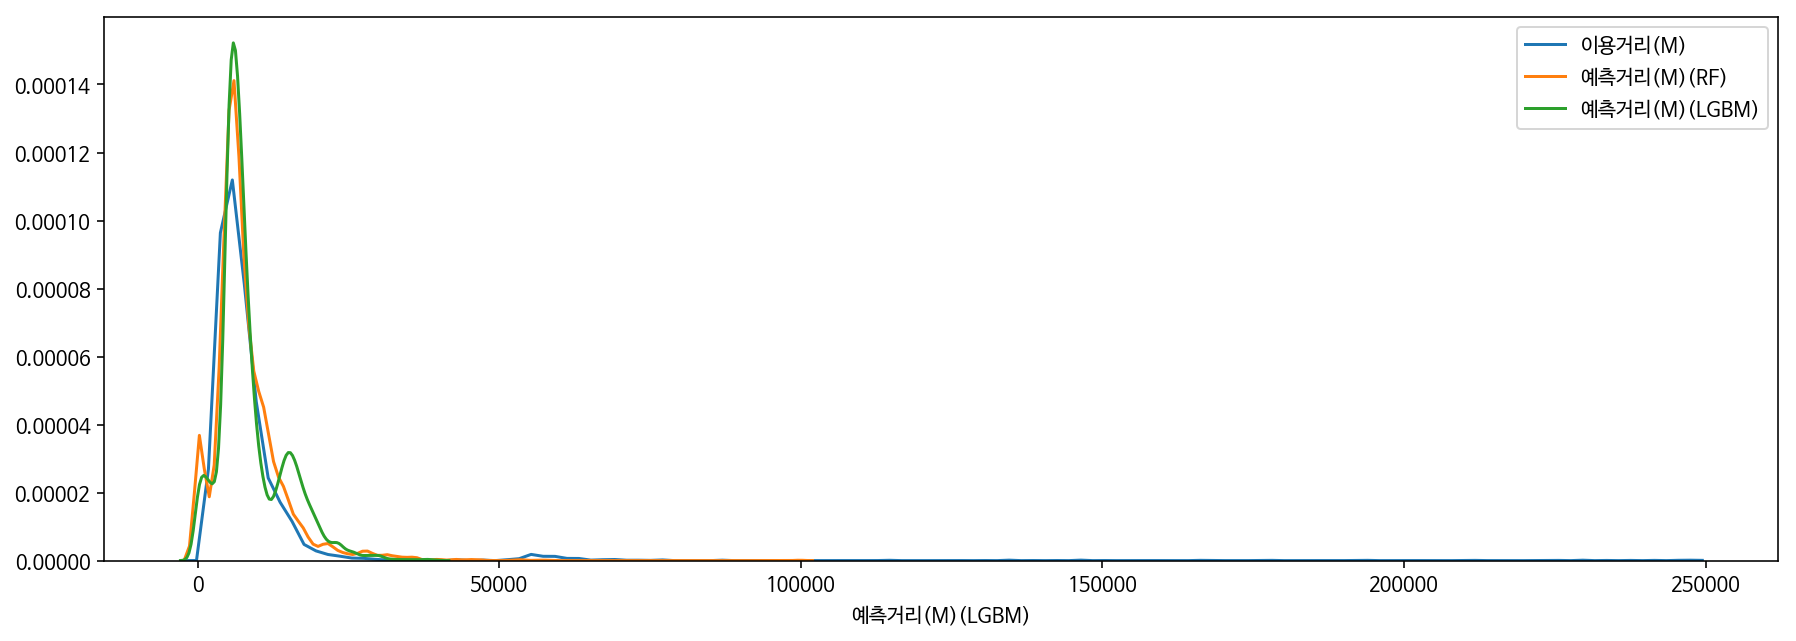

In [39]:
plt.figure(figsize=(15, 5))
sns.distplot(test[label_column], label=label_column, hist=False)
sns.distplot(test["예측거리(M)(RF)"], label="예측거리(M)(RF)", hist=False)
sns.distplot(test["예측거리(M)(LGBM)"], label="예측거리(M)(LGBM)", hist=False)

## 튜토리얼 만족도 설문

튜토리얼에 참여해 주셔서 감사합니다. 설문을 부탁드립니다. https://forms.gle/DPgkHozJNyGFACSv6